In [1]:
import os
import sys
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from data_preparation.data_loader import (
    load_dataset,
    split_train_validation,
    create_csv_submission,
    change_negative_class,
)
from data_preparation.features_util import keep_features, merge_features
from data_preparation.features_info import FEATURES_DICT, REPLACEMENT_LIST
from data_preparation.preprocessing import preprocessing_pipeline, basic_preprocessing_pipeline
from model.train import reg_logistic_regression
from model.predict import predict, predict_no_labels
from util.evaluation import evaluation_summary, accuracy, f1_score
from util.plotting import loss_visualization, decision_threshold
from util.util import init_random_seeds

init_random_seeds()

BASE_PATH = os.path.dirname(os.getcwd()) + "/data"

In [3]:
hyperparams = {
    "gamma": 1,
    "lambda": 0.00001,
    "batch_size": 10000
}

# Data loading

### ⚠️ Note that the `x_sub` here refers to data for which predictions will be made, but for which we don't have the labels! To refer to the data used for local testing we'll use `x_va` and `y_va` (validation).

In [4]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(
    path_x_train=BASE_PATH + "/x_train.csv",
    path_y_train=BASE_PATH + "/y_train.csv",
    path_x_test=BASE_PATH + "/x_test.csv",
    sub_sample=False,
)

# Create the feature index dictionary
feature_index = dict(zip(feature_names, range(len(feature_names))))

# Pre-processing

#### This notebook uses the GOOD pre-processing: only selected features are kept and pre-processed using the informed pre-processing pipeline

In [5]:
# Keeping only selected features both in train and validation set
x_train_clean, clean_features, clean_feature_index = keep_features(
    x_train, FEATURES_DICT.keys(), feature_names, feature_index, verbose=False
)

# Call to the informed preprocessing pipeline on the selected features
x_train_clean_proc = preprocessing_pipeline(
    x_train_clean,
    where=clean_features,
    feature_index=clean_feature_index,
    nan_replacement=REPLACEMENT_LIST,
    normalize="mixed",
)

## Data preparation and split sets

#### From now on we'll use the local train and validation data: `x_tr` and `y_tr` for training and `x_va` and `y_va` for validation

In [6]:
    # Translate labels from -1/1 to 0/1
y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(
    x_train_clean_proc, y_train, valid_proportion=0.1
)

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)

# Training

In [7]:
w, train_loss, valid_loss = reg_logistic_regression(
    x_tr_bias,
    y_tr,
    x_va_bias,
    y_va,
    lambda_=hyperparams["lambda"],
    max_iter=5000,
    gamma=hyperparams["gamma"],
    batch_size=hyperparams["batch_size"],
    optimizer="sgd",
    w=np.random.random(size=x_tr_bias.shape[1]),
    all_losses=True,
)

Iteration 0/5000 -> lowest loss inf
Iteration 200/5000 -> lowest loss 0.2198948256173206
Iteration 400/5000 -> lowest loss 0.21955697673283348
Iteration 600/5000 -> lowest loss 0.21926165003810877
Iteration 800/5000 -> lowest loss 0.21926165003810877
Iteration 1000/5000 -> lowest loss 0.21926165003810877
Iteration 1200/5000 -> lowest loss 0.21923161059728882
Iteration 1400/5000 -> lowest loss 0.21923161059728882
Iteration 1600/5000 -> lowest loss 0.21914037192112185
Iteration 1800/5000 -> lowest loss 0.21914037192112185
Iteration 2000/5000 -> lowest loss 0.21912631001033095
Iteration 2200/5000 -> lowest loss 0.21897498539091495
Iteration 2400/5000 -> lowest loss 0.21897498539091495
Iteration 2600/5000 -> lowest loss 0.21897498539091495
Iteration 2800/5000 -> lowest loss 0.21897498539091495
Iteration 3000/5000 -> lowest loss 0.21897498539091495
Iteration 3200/5000 -> lowest loss 0.21897498539091495
Iteration 3400/5000 -> lowest loss 0.2189697954508622
Iteration 3600/5000 -> lowest loss 

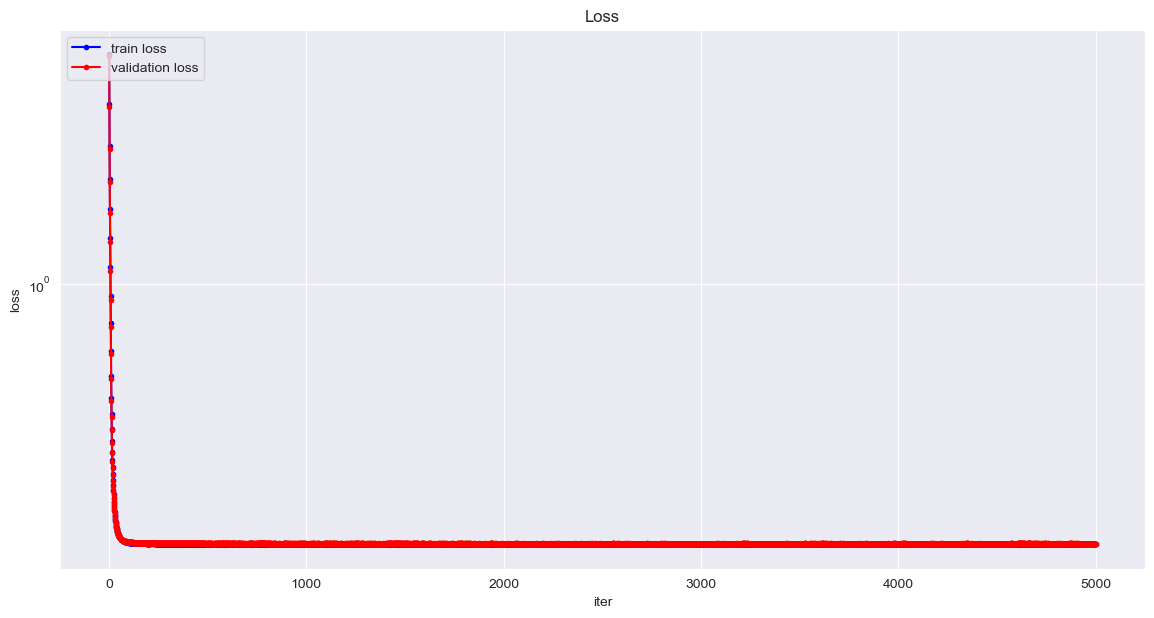

In [8]:
# plot losses
loss_visualization(train_loss, valid_loss)
plt.yscale("log")

# Evaluation on validation set

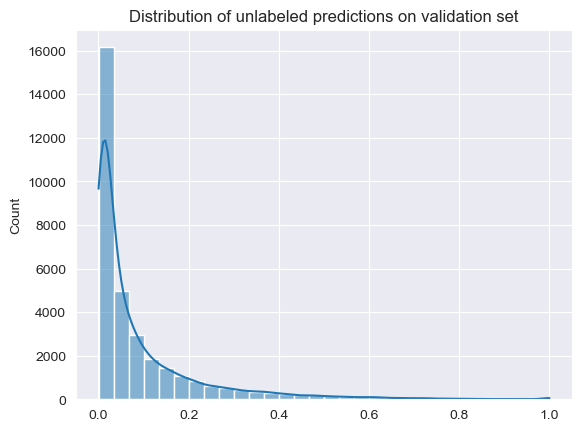

In [9]:
sns.histplot(predict_no_labels(x_va_bias, w), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on validation set")
plt.show()

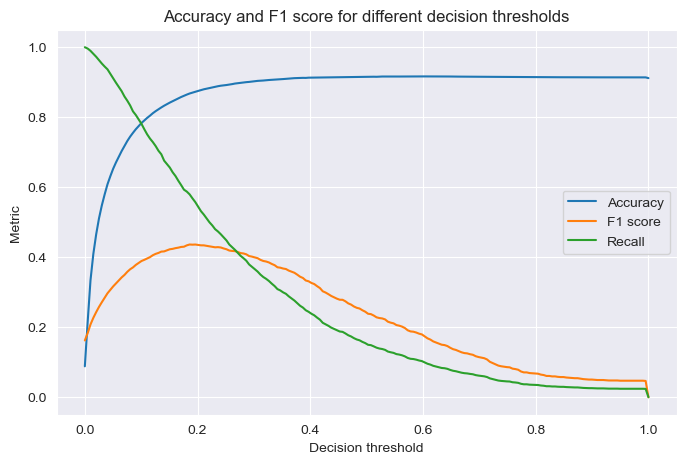

In [10]:
threshold_opt = decision_threshold(x_va_bias, w, y_va)

In [11]:
predicted_y_va = predict(x_va_bias,
                         w,
                         threshold=threshold_opt,
                         negative_label=0)
print("EVALUATION SUMMARY ON VALIDATION SET")
print("Threshold: {}".format(threshold_opt))
evaluation_summary(y_va, predicted_y_va)

EVALUATION SUMMARY ON VALIDATION SET
Threshold: 0.18592964824120603
Accuracy: 86.78%
Precision: 34.99%
Recall: 57.96%
F1-score: 43.63%



---

# COMPUTE RESULT FOR SUBMISSION

### Pre processing and data preparation

In [12]:
ids = x_sub[:, 0]
# Keep only selected features in submission
x_sub_clean, clean_features, clean_feature_index = keep_features(
    x_sub, FEATURES_DICT.keys(), feature_names, feature_index, verbose=False
)

x_sub_clean_proc = preprocessing_pipeline(
    x_sub_clean,
    where=clean_features,
    feature_index=clean_feature_index,
    nan_replacement=REPLACEMENT_LIST,
    normalize="mixed",
)

x_sub_dirty_proc = basic_preprocessing_pipeline(x_sub, where=[f for f in feature_names if f not in clean_features],
                                                feature_index=feature_index, normalize="min-max")

x_sub_merged = merge_features(
    x_big=x_sub_dirty_proc,
    feature_index_big=feature_index,
    x_small=x_sub_clean_proc,
    feature_index_small=clean_feature_index,
)

x_sub_bias = np.append(
    x_sub_merged, np.ones(shape=(x_sub_merged.shape[0], 1)), axis=1
)

### Prediction

In [ ]:
predicted_y_sub = predict(
    x_sub_bias, w, threshold=threshold_opt, negative_label=-1
)

# Save predictions to csv file
create_csv_submission(
    ids=ids, y_pred=predicted_y_sub, path=BASE_PATH + "/submission.csv"
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_va, ax=axs[0])
axs[0].set_title("Labels distribution in validation set")
sns.histplot(predicted_y_sub, ax=axs[1])
axs[1].set_title("Predictions distribution")